In [1]:
import sys, os
sys.path.append(os.path.dirname(sys.path[0]))


In [2]:
import numpy as np
import pandas as pd
import torch 
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# Data set
from RobotData import RobotsDataset, RobotsDatasetConcurrent

# Model
from net import Net
from DeepLab import DeepLab

# Loss function
from criterion import criterion

# Performance Metrics
from metric_detection import score, get_score
from metric_segmentation import IOU_run
from visualize import visualize_run

# Save results
from logger import Logger

# Transforms, which support different targets ('seg','det' or 'both')
import mode_transforms

# Loss function
from criterion import criterion

#
from test_cuda import test
from train import train, train_concurrent

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
modes = ['det','seg']


# Baseline


In [3]:

input_size = (4*3*32,4*4*32) # (5*3*32,5*4*32)
transform_dict = {}

for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode),
        mode_transforms.ToTensor(mode = mode),
        mode_transforms.Normalize(),
    ])

args = {'batch_size':12,
        'test_batch_size':1,
        'epochs': 25,
        'size_after_transform' : input_size,
        'lr': 0.0001,
        'max_lr':0.005,
        'gamma':0.7,
        'seed': 1234,
        'log_interval':10,
        'save_model':True,
        'l1':100,
        'l2':1,
        'l3':0,
        'transform' : transform_dict,
}

torch.manual_seed(args['seed'])


#train_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Train/'])
#test_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Test/'])

train_loc = "".join([os.path.dirname(sys.path[0]),'/data/Train/'])
test_loc = "".join([os.path.dirname(sys.path[0]),'/data/Test/'])

train_dataset = dict.fromkeys(modes, None) 
train_loader = dict.fromkeys(modes, None)
test_dataset = dict.fromkeys(modes, None) 
test_loader = dict.fromkeys(modes, None)

for mode in modes:
    train_dataset[mode] = RobotsDataset(data_loc = train_loc,mode = mode,transform=args['transform'][mode])
    train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=False)
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=args['transform'][mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
train_dataset['concurrent'] = RobotsDatasetConcurrent(data_loc = train_loc,transform_dict=args['transform'])
train_loader['concurrent'] = torch.utils.data.DataLoader(train_dataset['concurrent'],batch_size=args['batch_size'], shuffle=False)
test_dataset['concurrent'] = RobotsDatasetConcurrent(data_loc = test_loc,transform_dict=args['transform'])
test_loader['concurrent'] = torch.utils.data.DataLoader(test_dataset['concurrent'],batch_size=args['test_batch_size'], shuffle=False)

model = DeepLab(3,3,backbone='resnet18').to(device)

run_loc= "".join([os.path.dirname(sys.path[0]),'/Logs/experiments.csv'])
if os.path.isfile(run_loc):
    df = pd.read_csv(run_loc)
    run_id = max(df['run_id'])+1
else:
    run_id=0

run_name='baseline'
log_loc = "".join([os.path.dirname(sys.path[0]),f'/Logs/{run_name}_log.csv'])
logger = Logger(run_loc,log_loc,run_id,args)
    
optimizer = optim.Adam(model.parameters(), 0.0007)
scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)


resnet18


In [4]:
for epoch in range(1, args['epochs'] + 1):
    train_concurrent(args, model, device, train_loader['concurrent'], optimizer, epoch,logger=logger)
    test(args, model, device, test_loader['det'] , mode = 'det',logger=logger,visualise=False)
    test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger,visualise=False)
    scheduler.step()
    logger.log_data()
    torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_{epoch}.pt")

/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 1 [0/6195(0%)]	Loss: 7.734822, time: 1.6179118156433105
Train Epoch concurrent: 1 [120/6195(2%)]	Loss: 3.963106, time: 7.457815885543823
Train Epoch concurrent: 1 [240/6195(4%)]	Loss: 2.749975, time: 7.524585247039795
Train Epoch concurrent: 1 [360/6195(6%)]	Loss: 1.996193, time: 7.463996410369873
Train Epoch concurrent: 1 [480/6195(8%)]	Loss: 1.500898, time: 7.481810808181763
Train Epoch concurrent: 1 [600/6195(10%)]	Loss: 1.120137, time: 7.460979700088501
Train Epoch concurrent: 1 [720/6195(12%)]	Loss: 0.860807, time: 7.547253131866455
Train Epoch concurrent: 1 [840/6195(14%)]	Loss: 0.725471, time: 7.529242992401123
Train Epoch concurrent: 1 [960/6195(15%)]	Loss: 0.610965, time: 7.511948585510254
Train Epoch concurrent: 1 [1080/6195(17%)]	Loss: 0.609462, time: 7.605206251144409
Train Epoch concurrent: 1 [1200/6195(19%)]	Loss: 0.542344, time: 7.559505462646484
Train Epoch concurrent: 1 [1320/6195(21%)]	Loss: 0.511332, time: 7.50318169593811
Train Epoch concurre

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0027

Background: IOU: 0.94, accuracy: 0.98
Lines: IOU: 0.66, accuracy: 0.99
Field: IOU: 0.95, accuracy: 0.97
Total: IOU: 0.85, accuracy: 0.98
mean evaluation time: 0.0034 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 2 [0/6195(0%)]	Loss: 0.145928, time: 0.7087247371673584
Train Epoch concurrent: 2 [120/6195(2%)]	Loss: 0.123755, time: 7.5220301151275635
Train Epoch concurrent: 2 [240/6195(4%)]	Loss: 0.137329, time: 7.570674180984497
Train Epoch concurrent: 2 [360/6195(6%)]	Loss: 0.127781, time: 7.526285648345947
Train Epoch concurrent: 2 [480/6195(8%)]	Loss: 0.118831, time: 7.536820650100708
Train Epoch concurrent: 2 [600/6195(10%)]	Loss: 0.135303, time: 7.467887878417969
Train Epoch concurrent: 2 [720/6195(12%)]	Loss: 0.119431, time: 7.5911338329315186
Train Epoch concurrent: 2 [840/6195(14%)]	Loss: 0.132838, time: 7.58519434928894
Train Epoch concurrent: 2 [960/6195(15%)]	Loss: 0.122070, tim

Train Epoch concurrent: 3 [4440/6195(72%)]	Loss: 0.051921, time: 7.569047212600708
Train Epoch concurrent: 3 [4560/6195(74%)]	Loss: 0.048044, time: 7.53947114944458
Train Epoch concurrent: 3 [4680/6195(75%)]	Loss: 0.049645, time: 7.642623424530029
Train Epoch concurrent: 3 [4800/6195(77%)]	Loss: 0.050618, time: 7.460190057754517
Train Epoch concurrent: 3 [4920/6195(79%)]	Loss: 0.047417, time: 7.492621898651123
Train Epoch concurrent: 3 [5040/6195(81%)]	Loss: 0.050831, time: 7.576459884643555
Train Epoch concurrent: 3 [5160/6195(83%)]	Loss: 0.047477, time: 7.5865137577056885
Train Epoch concurrent: 3 [5280/6195(85%)]	Loss: 0.046966, time: 7.605387210845947
Train Epoch concurrent: 3 [5400/6195(87%)]	Loss: 0.043402, time: 7.468484401702881
Train Epoch concurrent: 3 [5520/6195(89%)]	Loss: 0.051762, time: 7.6208789348602295
Train Epoch concurrent: 3 [5640/6195(91%)]	Loss: 0.046174, time: 7.547677993774414
Train Epoch concurrent: 3 [5760/6195(93%)]	Loss: 0.044791, time: 7.541611909866333
Tra

Train Epoch concurrent: 5 [2160/6195(35%)]	Loss: 0.021065, time: 7.517050743103027
Train Epoch concurrent: 5 [2280/6195(37%)]	Loss: 0.021124, time: 7.595561742782593
Train Epoch concurrent: 5 [2400/6195(39%)]	Loss: 0.020281, time: 7.565770864486694
Train Epoch concurrent: 5 [2520/6195(41%)]	Loss: 0.017538, time: 7.553978681564331
Train Epoch concurrent: 5 [2640/6195(43%)]	Loss: 0.021006, time: 7.58134913444519
Train Epoch concurrent: 5 [2760/6195(44%)]	Loss: 0.019746, time: 7.579911231994629
Train Epoch concurrent: 5 [2880/6195(46%)]	Loss: 0.017527, time: 7.552591800689697
Train Epoch concurrent: 5 [3000/6195(48%)]	Loss: 0.019740, time: 7.573586702346802
Train Epoch concurrent: 5 [3120/6195(50%)]	Loss: 0.021144, time: 7.478099822998047
Train Epoch concurrent: 5 [3240/6195(52%)]	Loss: 0.020858, time: 7.545217514038086
Train Epoch concurrent: 5 [3360/6195(54%)]	Loss: 0.017391, time: 7.569256544113159
Train Epoch concurrent: 5 [3480/6195(56%)]	Loss: 0.020886, time: 7.586102247238159
Train

Train Epoch concurrent: 7 [0/6195(0%)]	Loss: 0.012232, time: 0.6998209953308105
Train Epoch concurrent: 7 [120/6195(2%)]	Loss: 0.010897, time: 7.51356840133667
Train Epoch concurrent: 7 [240/6195(4%)]	Loss: 0.013046, time: 7.571382284164429
Train Epoch concurrent: 7 [360/6195(6%)]	Loss: 0.011922, time: 7.559866905212402
Train Epoch concurrent: 7 [480/6195(8%)]	Loss: 0.011816, time: 7.582514047622681
Train Epoch concurrent: 7 [600/6195(10%)]	Loss: 0.013018, time: 7.498265027999878
Train Epoch concurrent: 7 [720/6195(12%)]	Loss: 0.012994, time: 7.6357972621917725
Train Epoch concurrent: 7 [840/6195(14%)]	Loss: 0.012472, time: 7.590569972991943
Train Epoch concurrent: 7 [960/6195(15%)]	Loss: 0.009986, time: 7.564234018325806
Train Epoch concurrent: 7 [1080/6195(17%)]	Loss: 0.009700, time: 7.608322858810425
Train Epoch concurrent: 7 [1200/6195(19%)]	Loss: 0.010619, time: 7.6003499031066895
Train Epoch concurrent: 7 [1320/6195(21%)]	Loss: 0.011603, time: 7.54510235786438
Train Epoch concurr

Train Epoch concurrent: 8 [4800/6195(77%)]	Loss: 0.008852, time: 7.492027521133423
Train Epoch concurrent: 8 [4920/6195(79%)]	Loss: 0.007895, time: 7.507863759994507
Train Epoch concurrent: 8 [5040/6195(81%)]	Loss: 0.006573, time: 7.566328525543213
Train Epoch concurrent: 8 [5160/6195(83%)]	Loss: 0.007140, time: 7.582742214202881
Train Epoch concurrent: 8 [5280/6195(85%)]	Loss: 0.008678, time: 7.587257146835327
Train Epoch concurrent: 8 [5400/6195(87%)]	Loss: 0.007751, time: 7.449530601501465
Train Epoch concurrent: 8 [5520/6195(89%)]	Loss: 0.009268, time: 7.634800910949707
Train Epoch concurrent: 8 [5640/6195(91%)]	Loss: 0.007994, time: 7.589407682418823
Train Epoch concurrent: 8 [5760/6195(93%)]	Loss: 0.008885, time: 7.529993295669556
Train Epoch concurrent: 8 [5880/6195(95%)]	Loss: 0.006625, time: 7.609451532363892
Train Epoch concurrent: 8 [6000/6195(97%)]	Loss: 0.006262, time: 7.531172752380371
Train Epoch concurrent: 8 [6120/6195(99%)]	Loss: 0.006473, time: 7.570154190063477

Tes

Train Epoch concurrent: 10 [2520/6195(41%)]	Loss: 0.005232, time: 7.580791711807251
Train Epoch concurrent: 10 [2640/6195(43%)]	Loss: 0.007284, time: 7.570587873458862
Train Epoch concurrent: 10 [2760/6195(44%)]	Loss: 0.005151, time: 7.601061582565308
Train Epoch concurrent: 10 [2880/6195(46%)]	Loss: 0.004815, time: 7.559200048446655
Train Epoch concurrent: 10 [3000/6195(48%)]	Loss: 0.005286, time: 7.5875244140625
Train Epoch concurrent: 10 [3120/6195(50%)]	Loss: 0.005849, time: 7.512064218521118
Train Epoch concurrent: 10 [3240/6195(52%)]	Loss: 0.006223, time: 7.5469746589660645
Train Epoch concurrent: 10 [3360/6195(54%)]	Loss: 0.005189, time: 7.680501461029053
Train Epoch concurrent: 10 [3480/6195(56%)]	Loss: 0.005990, time: 7.636535167694092
Train Epoch concurrent: 10 [3600/6195(58%)]	Loss: 0.004932, time: 7.562775373458862
Train Epoch concurrent: 10 [3720/6195(60%)]	Loss: 0.005469, time: 7.551695823669434
Train Epoch concurrent: 10 [3840/6195(62%)]	Loss: 0.005137, time: 7.565717697

Train Epoch concurrent: 12 [120/6195(2%)]	Loss: 0.004295, time: 7.516087055206299
Train Epoch concurrent: 12 [240/6195(4%)]	Loss: 0.004537, time: 7.542937755584717
Train Epoch concurrent: 12 [360/6195(6%)]	Loss: 0.004313, time: 7.520022869110107
Train Epoch concurrent: 12 [480/6195(8%)]	Loss: 0.004379, time: 7.528329610824585
Train Epoch concurrent: 12 [600/6195(10%)]	Loss: 0.005404, time: 7.550446271896362
Train Epoch concurrent: 12 [720/6195(12%)]	Loss: 0.005100, time: 7.611007452011108
Train Epoch concurrent: 12 [840/6195(14%)]	Loss: 0.004408, time: 7.562741994857788
Train Epoch concurrent: 12 [960/6195(15%)]	Loss: 0.003500, time: 7.567499399185181
Train Epoch concurrent: 12 [1080/6195(17%)]	Loss: 0.003955, time: 7.622408390045166
Train Epoch concurrent: 12 [1200/6195(19%)]	Loss: 0.004081, time: 7.615173578262329
Train Epoch concurrent: 12 [1320/6195(21%)]	Loss: 0.003725, time: 7.522124528884888
Train Epoch concurrent: 12 [1440/6195(23%)]	Loss: 0.003207, time: 7.606256723403931
Trai

Train Epoch concurrent: 13 [4800/6195(77%)]	Loss: 0.003955, time: 7.4967286586761475
Train Epoch concurrent: 13 [4920/6195(79%)]	Loss: 0.002970, time: 7.534234285354614
Train Epoch concurrent: 13 [5040/6195(81%)]	Loss: 0.002766, time: 7.581448316574097
Train Epoch concurrent: 13 [5160/6195(83%)]	Loss: 0.003794, time: 7.610596418380737
Train Epoch concurrent: 13 [5280/6195(85%)]	Loss: 0.003558, time: 7.592503547668457
Train Epoch concurrent: 13 [5400/6195(87%)]	Loss: 0.003782, time: 7.499786376953125
Train Epoch concurrent: 13 [5520/6195(89%)]	Loss: 0.004256, time: 7.644531011581421
Train Epoch concurrent: 13 [5640/6195(91%)]	Loss: 0.003750, time: 7.577434062957764
Train Epoch concurrent: 13 [5760/6195(93%)]	Loss: 0.003568, time: 7.541182518005371
Train Epoch concurrent: 13 [5880/6195(95%)]	Loss: 0.003088, time: 7.588386297225952
Train Epoch concurrent: 13 [6000/6195(97%)]	Loss: 0.002578, time: 7.528703212738037
Train Epoch concurrent: 13 [6120/6195(99%)]	Loss: 0.002996, time: 7.6167652

Train Epoch concurrent: 15 [2400/6195(39%)]	Loss: 0.003424, time: 7.598938465118408
Train Epoch concurrent: 15 [2520/6195(41%)]	Loss: 0.002999, time: 7.558345794677734
Train Epoch concurrent: 15 [2640/6195(43%)]	Loss: 0.004050, time: 7.613627910614014
Train Epoch concurrent: 15 [2760/6195(44%)]	Loss: 0.002963, time: 7.5973076820373535
Train Epoch concurrent: 15 [2880/6195(46%)]	Loss: 0.003012, time: 7.586286306381226
Train Epoch concurrent: 15 [3000/6195(48%)]	Loss: 0.003033, time: 7.606213331222534
Train Epoch concurrent: 15 [3120/6195(50%)]	Loss: 0.002965, time: 7.555584192276001
Train Epoch concurrent: 15 [3240/6195(52%)]	Loss: 0.003891, time: 7.546660423278809
Train Epoch concurrent: 15 [3360/6195(54%)]	Loss: 0.002722, time: 7.643547773361206
Train Epoch concurrent: 15 [3480/6195(56%)]	Loss: 0.003127, time: 7.64113187789917
Train Epoch concurrent: 15 [3600/6195(58%)]	Loss: 0.002750, time: 7.553827285766602
Train Epoch concurrent: 15 [3720/6195(60%)]	Loss: 0.002710, time: 7.52568578

Train Epoch concurrent: 17 [0/6195(0%)]	Loss: 0.003257, time: 0.7011947631835938
Train Epoch concurrent: 17 [120/6195(2%)]	Loss: 0.002533, time: 7.499078273773193
Train Epoch concurrent: 17 [240/6195(4%)]	Loss: 0.002579, time: 7.564188241958618
Train Epoch concurrent: 17 [360/6195(6%)]	Loss: 0.002563, time: 7.527958631515503
Train Epoch concurrent: 17 [480/6195(8%)]	Loss: 0.003336, time: 7.539281845092773
Train Epoch concurrent: 17 [600/6195(10%)]	Loss: 0.003445, time: 7.526070833206177
Train Epoch concurrent: 17 [720/6195(12%)]	Loss: 0.003037, time: 7.582728385925293
Train Epoch concurrent: 17 [840/6195(14%)]	Loss: 0.003011, time: 7.605576515197754
Train Epoch concurrent: 17 [960/6195(15%)]	Loss: 0.002233, time: 7.603980779647827
Train Epoch concurrent: 17 [1080/6195(17%)]	Loss: 0.002540, time: 7.657618999481201
Train Epoch concurrent: 17 [1200/6195(19%)]	Loss: 0.002743, time: 7.603039264678955
Train Epoch concurrent: 17 [1320/6195(21%)]	Loss: 0.002927, time: 7.557880640029907
Train E

Train Epoch concurrent: 18 [4680/6195(75%)]	Loss: 0.003061, time: 7.631674289703369
Train Epoch concurrent: 18 [4800/6195(77%)]	Loss: 0.002565, time: 7.4743006229400635
Train Epoch concurrent: 18 [4920/6195(79%)]	Loss: 0.002123, time: 7.538254976272583
Train Epoch concurrent: 18 [5040/6195(81%)]	Loss: 0.002093, time: 7.554615497589111
Train Epoch concurrent: 18 [5160/6195(83%)]	Loss: 0.002340, time: 7.593018293380737
Train Epoch concurrent: 18 [5280/6195(85%)]	Loss: 0.002462, time: 7.618483543395996
Train Epoch concurrent: 18 [5400/6195(87%)]	Loss: 0.002617, time: 7.478206634521484
Train Epoch concurrent: 18 [5520/6195(89%)]	Loss: 0.002570, time: 7.635023355484009
Train Epoch concurrent: 18 [5640/6195(91%)]	Loss: 0.002430, time: 7.57884955406189
Train Epoch concurrent: 18 [5760/6195(93%)]	Loss: 0.002388, time: 7.568323135375977
Train Epoch concurrent: 18 [5880/6195(95%)]	Loss: 0.002232, time: 7.613320350646973
Train Epoch concurrent: 18 [6000/6195(97%)]	Loss: 0.002037, time: 7.55326867

Train Epoch concurrent: 20 [2280/6195(37%)]	Loss: 0.002989, time: 7.577829122543335
Train Epoch concurrent: 20 [2400/6195(39%)]	Loss: 0.003381, time: 7.552785873413086
Train Epoch concurrent: 20 [2520/6195(41%)]	Loss: 0.002906, time: 7.584396123886108
Train Epoch concurrent: 20 [2640/6195(43%)]	Loss: 0.004216, time: 7.598661661148071
Train Epoch concurrent: 20 [2760/6195(44%)]	Loss: 0.002984, time: 7.57012414932251
Train Epoch concurrent: 20 [2880/6195(46%)]	Loss: 0.002894, time: 7.621531009674072
Train Epoch concurrent: 20 [3000/6195(48%)]	Loss: 0.003159, time: 7.617563962936401
Train Epoch concurrent: 20 [3120/6195(50%)]	Loss: 0.004059, time: 7.478641748428345
Train Epoch concurrent: 20 [3240/6195(52%)]	Loss: 0.003513, time: 7.571758985519409
Train Epoch concurrent: 20 [3360/6195(54%)]	Loss: 0.002600, time: 7.62114405632019
Train Epoch concurrent: 20 [3480/6195(56%)]	Loss: 0.003314, time: 7.612447261810303
Train Epoch concurrent: 20 [3600/6195(58%)]	Loss: 0.002424, time: 7.5799546241

Train Epoch concurrent: 22 [0/6195(0%)]	Loss: 0.002403, time: 0.7026054859161377
Train Epoch concurrent: 22 [120/6195(2%)]	Loss: 0.001685, time: 7.516241788864136
Train Epoch concurrent: 22 [240/6195(4%)]	Loss: 0.001708, time: 7.57458758354187
Train Epoch concurrent: 22 [360/6195(6%)]	Loss: 0.001785, time: 7.501916885375977
Train Epoch concurrent: 22 [480/6195(8%)]	Loss: 0.002308, time: 7.539106607437134
Train Epoch concurrent: 22 [600/6195(10%)]	Loss: 0.002723, time: 7.502698183059692
Train Epoch concurrent: 22 [720/6195(12%)]	Loss: 0.001990, time: 7.5946643352508545
Train Epoch concurrent: 22 [840/6195(14%)]	Loss: 0.001994, time: 7.583402872085571
Train Epoch concurrent: 22 [960/6195(15%)]	Loss: 0.001565, time: 7.567146062850952
Train Epoch concurrent: 22 [1080/6195(17%)]	Loss: 0.001400, time: 7.625959634780884
Train Epoch concurrent: 22 [1200/6195(19%)]	Loss: 0.001605, time: 7.631078720092773
Train Epoch concurrent: 22 [1320/6195(21%)]	Loss: 0.001576, time: 7.583661794662476
Train E

Train Epoch concurrent: 23 [4680/6195(75%)]	Loss: 0.002046, time: 7.608815431594849
Train Epoch concurrent: 23 [4800/6195(77%)]	Loss: 0.001982, time: 7.504867792129517
Train Epoch concurrent: 23 [4920/6195(79%)]	Loss: 0.001765, time: 7.5388023853302
Train Epoch concurrent: 23 [5040/6195(81%)]	Loss: 0.001370, time: 7.577671051025391
Train Epoch concurrent: 23 [5160/6195(83%)]	Loss: 0.001698, time: 7.582023859024048
Train Epoch concurrent: 23 [5280/6195(85%)]	Loss: 0.001892, time: 7.611627101898193
Train Epoch concurrent: 23 [5400/6195(87%)]	Loss: 0.001947, time: 7.500858545303345
Train Epoch concurrent: 23 [5520/6195(89%)]	Loss: 0.002153, time: 7.645185470581055
Train Epoch concurrent: 23 [5640/6195(91%)]	Loss: 0.001709, time: 7.581090927124023
Train Epoch concurrent: 23 [5760/6195(93%)]	Loss: 0.001873, time: 7.532729387283325
Train Epoch concurrent: 23 [5880/6195(95%)]	Loss: 0.001634, time: 7.625370264053345
Train Epoch concurrent: 23 [6000/6195(97%)]	Loss: 0.001404, time: 7.5696928501

Train Epoch concurrent: 25 [2280/6195(37%)]	Loss: 0.001684, time: 8.789246559143066
Train Epoch concurrent: 25 [2400/6195(39%)]	Loss: 0.001843, time: 8.717458248138428
Train Epoch concurrent: 25 [2520/6195(41%)]	Loss: 0.001284, time: 8.937034606933594
Train Epoch concurrent: 25 [2640/6195(43%)]	Loss: 0.001649, time: 8.644274473190308
Train Epoch concurrent: 25 [2760/6195(44%)]	Loss: 0.001301, time: 8.809124231338501
Train Epoch concurrent: 25 [2880/6195(46%)]	Loss: 0.001126, time: 8.805854320526123
Train Epoch concurrent: 25 [3000/6195(48%)]	Loss: 0.001288, time: 8.74512767791748
Train Epoch concurrent: 25 [3120/6195(50%)]	Loss: 0.001238, time: 8.64777159690857
Train Epoch concurrent: 25 [3240/6195(52%)]	Loss: 0.001746, time: 8.800854921340942
Train Epoch concurrent: 25 [3360/6195(54%)]	Loss: 0.001559, time: 8.951439619064331
Train Epoch concurrent: 25 [3480/6195(56%)]	Loss: 0.001573, time: 8.819234609603882
Train Epoch concurrent: 25 [3600/6195(58%)]	Loss: 0.001211, time: 8.7603895664

In [6]:
for epoch in range(26, args['epochs'] + 26):
    train_concurrent(args, model, device, train_loader['concurrent'], optimizer, epoch,logger=logger)
    test(args, model, device, test_loader['det'] , mode = 'det',logger=logger,visualise=False)
    test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger,visualise=False)
    scheduler.step()
    logger.log_data()
    torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_{epoch}.pt")

/home/user/jacobs/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 26 [0/6195(0%)]	Loss: 0.001427, time: 0.7400681972503662
Train Epoch concurrent: 26 [120/6195(2%)]	Loss: 0.001286, time: 7.399245262145996
Train Epoch concurrent: 26 [240/6195(4%)]	Loss: 0.001250, time: 7.448227167129517
Train Epoch concurrent: 26 [360/6195(6%)]	Loss: 0.001467, time: 7.429356813430786
Train Epoch concurrent: 26 [480/6195(8%)]	Loss: 0.001963, time: 7.4183666706085205
Train Epoch concurrent: 26 [600/6195(10%)]	Loss: 0.002453, time: 7.410950422286987
Train Epoch concurrent: 26 [720/6195(12%)]	Loss: 0.001748, time: 7.504963159561157
Train Epoch concurrent: 26 [840/6195(14%)]	Loss: 0.001806, time: 7.519906282424927
Train Epoch concurrent: 26 [960/6195(15%)]	Loss: 0.001156, time: 7.481585264205933
Train Epoch concurrent: 26 [1080/6195(17%)]	Loss: 0.001117, time: 7.55340313911438
Train Epoch concurrent: 26 [1200/6195(19%)]	Loss: 0.001225, time: 7.558055400848389
Train Epoch concurrent: 26 [1320/6195(21%)]	Loss: 0.001176, time: 7.450118064880371
Train E

/home/user/jacobs/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0019

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.79, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0048 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 27 [0/6195(0%)]	Loss: 0.001071, time: 0.8492424488067627
Train Epoch concurrent: 27 [120/6195(2%)]	Loss: 0.001057, time: 8.802852153778076
Train Epoch concurrent: 27 [240/6195(4%)]	Loss: 0.001253, time: 8.937812805175781
Train Epoch concurrent: 27 [360/6195(6%)]	Loss: 0.001552, time: 7.786777019500732
Train Epoch concurrent: 27 [480/6195(8%)]	Loss: 0.001565, time: 7.508237361907959
Train Epoch concurrent: 27 [600/6195(10%)]	Loss: 0.001984, time: 7.505857467651367
Train Epoch concurrent: 27 [720/6195(12%)]	Loss: 0.001592, time: 7.574268579483032
Train Epoch concurrent: 27 [840/6195(14%)]	Loss: 0.001336, time: 7.639310359954834
Train Epoch concurrent: 27 [960/6195(15%)]	Loss: 0.001

Train Epoch concurrent: 28 [4320/6195(70%)]	Loss: 0.001264, time: 8.854714155197144
Train Epoch concurrent: 28 [4440/6195(72%)]	Loss: 0.001056, time: 8.591613054275513
Train Epoch concurrent: 28 [4560/6195(74%)]	Loss: 0.001259, time: 8.684895753860474
Train Epoch concurrent: 28 [4680/6195(75%)]	Loss: 0.001407, time: 8.779958724975586
Train Epoch concurrent: 28 [4800/6195(77%)]	Loss: 0.001535, time: 8.632045030593872
Train Epoch concurrent: 28 [4920/6195(79%)]	Loss: 0.001146, time: 9.037390232086182
Train Epoch concurrent: 28 [5040/6195(81%)]	Loss: 0.001031, time: 8.777175664901733
Train Epoch concurrent: 28 [5160/6195(83%)]	Loss: 0.001219, time: 8.668532133102417
Train Epoch concurrent: 28 [5280/6195(85%)]	Loss: 0.001232, time: 8.759151458740234
Train Epoch concurrent: 28 [5400/6195(87%)]	Loss: 0.001259, time: 8.596698760986328
Train Epoch concurrent: 28 [5520/6195(89%)]	Loss: 0.001399, time: 8.903157472610474
Train Epoch concurrent: 28 [5640/6195(91%)]	Loss: 0.001364, time: 8.66907262

Train Epoch concurrent: 30 [1920/6195(31%)]	Loss: 0.000796, time: 8.590412616729736
Train Epoch concurrent: 30 [2040/6195(33%)]	Loss: 0.000878, time: 8.788073062896729
Train Epoch concurrent: 30 [2160/6195(35%)]	Loss: 0.001050, time: 8.751954555511475
Train Epoch concurrent: 30 [2280/6195(37%)]	Loss: 0.000882, time: 8.751612186431885
Train Epoch concurrent: 30 [2400/6195(39%)]	Loss: 0.000977, time: 8.917827129364014
Train Epoch concurrent: 30 [2520/6195(41%)]	Loss: 0.000864, time: 8.545945167541504
Train Epoch concurrent: 30 [2640/6195(43%)]	Loss: 0.001209, time: 8.734180688858032
Train Epoch concurrent: 30 [2760/6195(44%)]	Loss: 0.001068, time: 8.635438203811646
Train Epoch concurrent: 30 [2880/6195(46%)]	Loss: 0.001026, time: 8.969894647598267
Train Epoch concurrent: 30 [3000/6195(48%)]	Loss: 0.001045, time: 8.709682941436768
Train Epoch concurrent: 30 [3120/6195(50%)]	Loss: 0.001015, time: 8.649476528167725
Train Epoch concurrent: 30 [3240/6195(52%)]	Loss: 0.001271, time: 8.62875223


Test set: seg Average loss: 0.0021

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.79, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0043 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 32 [0/6195(0%)]	Loss: 0.000947, time: 0.8232922554016113
Train Epoch concurrent: 32 [120/6195(2%)]	Loss: 0.000928, time: 8.422177791595459
Train Epoch concurrent: 32 [240/6195(4%)]	Loss: 0.000946, time: 8.691649198532104
Train Epoch concurrent: 32 [360/6195(6%)]	Loss: 0.001411, time: 8.707580327987671
Train Epoch concurrent: 32 [480/6195(8%)]	Loss: 0.001262, time: 8.691913604736328
Train Epoch concurrent: 32 [600/6195(10%)]	Loss: 0.001295, time: 8.550978422164917
Train Epoch concurrent: 32 [720/6195(12%)]	Loss: 0.001253, time: 8.759945154190063
Train Epoch concurrent: 32 [840/6195(14%)]	Loss: 0.001187, time: 8.897059440612793
Train Epoch concurrent: 32 [960/6195(15%)]	Loss: 0.001

Train Epoch concurrent: 33 [4320/6195(70%)]	Loss: 0.000771, time: 8.68759298324585
Train Epoch concurrent: 33 [4440/6195(72%)]	Loss: 0.000723, time: 8.793140888214111
Train Epoch concurrent: 33 [4560/6195(74%)]	Loss: 0.000948, time: 8.74704098701477
Train Epoch concurrent: 33 [4680/6195(75%)]	Loss: 0.000914, time: 8.93622612953186
Train Epoch concurrent: 33 [4800/6195(77%)]	Loss: 0.001019, time: 8.76898455619812
Train Epoch concurrent: 33 [4920/6195(79%)]	Loss: 0.000783, time: 8.585415363311768
Train Epoch concurrent: 33 [5040/6195(81%)]	Loss: 0.001129, time: 8.723692893981934
Train Epoch concurrent: 33 [5160/6195(83%)]	Loss: 0.000803, time: 8.785914421081543
Train Epoch concurrent: 33 [5280/6195(85%)]	Loss: 0.001051, time: 8.632680416107178
Train Epoch concurrent: 33 [5400/6195(87%)]	Loss: 0.000911, time: 8.610049962997437
Train Epoch concurrent: 33 [5520/6195(89%)]	Loss: 0.001314, time: 8.97534704208374
Train Epoch concurrent: 33 [5640/6195(91%)]	Loss: 0.000713, time: 8.7141890525817

Train Epoch concurrent: 35 [1920/6195(31%)]	Loss: 0.001114, time: 9.506564617156982
Train Epoch concurrent: 35 [2040/6195(33%)]	Loss: 0.001400, time: 9.180438041687012
Train Epoch concurrent: 35 [2160/6195(35%)]	Loss: 0.001509, time: 8.653552770614624
Train Epoch concurrent: 35 [2280/6195(37%)]	Loss: 0.001287, time: 8.593540668487549
Train Epoch concurrent: 35 [2400/6195(39%)]	Loss: 0.001606, time: 8.66773271560669
Train Epoch concurrent: 35 [2520/6195(41%)]	Loss: 0.001097, time: 8.747249603271484
Train Epoch concurrent: 35 [2640/6195(43%)]	Loss: 0.001612, time: 8.654139041900635
Train Epoch concurrent: 35 [2760/6195(44%)]	Loss: 0.001147, time: 8.502524375915527
Train Epoch concurrent: 35 [2880/6195(46%)]	Loss: 0.001272, time: 8.465065240859985
Train Epoch concurrent: 35 [3000/6195(48%)]	Loss: 0.001153, time: 8.621853590011597
Train Epoch concurrent: 35 [3120/6195(50%)]	Loss: 0.001021, time: 8.560944318771362
Train Epoch concurrent: 35 [3240/6195(52%)]	Loss: 0.001727, time: 8.617641210


Test set: seg Average loss: 0.0024

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.79, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0046 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 37 [0/6195(0%)]	Loss: 0.000685, time: 0.7930681705474854
Train Epoch concurrent: 37 [120/6195(2%)]	Loss: 0.000644, time: 8.897404432296753
Train Epoch concurrent: 37 [240/6195(4%)]	Loss: 0.000741, time: 8.776280164718628
Train Epoch concurrent: 37 [360/6195(6%)]	Loss: 0.000826, time: 8.76280927658081
Train Epoch concurrent: 37 [480/6195(8%)]	Loss: 0.000753, time: 8.633108377456665
Train Epoch concurrent: 37 [600/6195(10%)]	Loss: 0.000818, time: 8.619317770004272
Train Epoch concurrent: 37 [720/6195(12%)]	Loss: 0.001158, time: 8.696113109588623
Train Epoch concurrent: 37 [840/6195(14%)]	Loss: 0.000758, time: 8.657589197158813
Train Epoch concurrent: 37 [960/6195(15%)]	Loss: 0.0005

Train Epoch concurrent: 38 [4320/6195(70%)]	Loss: 0.000621, time: 8.658177375793457
Train Epoch concurrent: 38 [4440/6195(72%)]	Loss: 0.000511, time: 8.56666898727417
Train Epoch concurrent: 38 [4560/6195(74%)]	Loss: 0.000692, time: 8.794491052627563
Train Epoch concurrent: 38 [4680/6195(75%)]	Loss: 0.000987, time: 8.718887567520142
Train Epoch concurrent: 38 [4800/6195(77%)]	Loss: 0.000926, time: 8.615211725234985
Train Epoch concurrent: 38 [4920/6195(79%)]	Loss: 0.000600, time: 8.707869052886963
Train Epoch concurrent: 38 [5040/6195(81%)]	Loss: 0.000565, time: 8.83824896812439
Train Epoch concurrent: 38 [5160/6195(83%)]	Loss: 0.000572, time: 8.70771598815918
Train Epoch concurrent: 38 [5280/6195(85%)]	Loss: 0.000599, time: 8.892195701599121
Train Epoch concurrent: 38 [5400/6195(87%)]	Loss: 0.000677, time: 8.594560623168945
Train Epoch concurrent: 38 [5520/6195(89%)]	Loss: 0.001162, time: 8.786017656326294
Train Epoch concurrent: 38 [5640/6195(91%)]	Loss: 0.000936, time: 8.77627110481

Train Epoch concurrent: 40 [1920/6195(31%)]	Loss: 0.000450, time: 8.650163412094116
Train Epoch concurrent: 40 [2040/6195(33%)]	Loss: 0.000642, time: 8.603569030761719
Train Epoch concurrent: 40 [2160/6195(35%)]	Loss: 0.000610, time: 8.548666715621948
Train Epoch concurrent: 40 [2280/6195(37%)]	Loss: 0.000847, time: 8.71610426902771
Train Epoch concurrent: 40 [2400/6195(39%)]	Loss: 0.000624, time: 8.963257551193237
Train Epoch concurrent: 40 [2520/6195(41%)]	Loss: 0.000636, time: 8.891945123672485
Train Epoch concurrent: 40 [2640/6195(43%)]	Loss: 0.000712, time: 8.687087535858154
Train Epoch concurrent: 40 [2760/6195(44%)]	Loss: 0.000555, time: 8.791727304458618
Train Epoch concurrent: 40 [2880/6195(46%)]	Loss: 0.000494, time: 8.618512630462646
Train Epoch concurrent: 40 [3000/6195(48%)]	Loss: 0.000504, time: 8.70439100265503
Train Epoch concurrent: 40 [3120/6195(50%)]	Loss: 0.000559, time: 8.657032489776611
Train Epoch concurrent: 40 [3240/6195(52%)]	Loss: 0.000788, time: 8.9206240177


Test set: seg Average loss: 0.0026

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.79, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0047 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 42 [0/6195(0%)]	Loss: 0.000808, time: 0.8027734756469727
Train Epoch concurrent: 42 [120/6195(2%)]	Loss: 0.000669, time: 8.771951675415039
Train Epoch concurrent: 42 [240/6195(4%)]	Loss: 0.000657, time: 8.870051622390747
Train Epoch concurrent: 42 [360/6195(6%)]	Loss: 0.000877, time: 8.701723098754883
Train Epoch concurrent: 42 [480/6195(8%)]	Loss: 0.000841, time: 8.681504964828491
Train Epoch concurrent: 42 [600/6195(10%)]	Loss: 0.000908, time: 8.422738552093506
Train Epoch concurrent: 42 [720/6195(12%)]	Loss: 0.000906, time: 8.769991397857666
Train Epoch concurrent: 42 [840/6195(14%)]	Loss: 0.000769, time: 8.678603172302246
Train Epoch concurrent: 42 [960/6195(15%)]	Loss: 0.000

Train Epoch concurrent: 43 [4320/6195(70%)]	Loss: 0.000559, time: 8.74575686454773
Train Epoch concurrent: 43 [4440/6195(72%)]	Loss: 0.000464, time: 8.623631477355957
Train Epoch concurrent: 43 [4560/6195(74%)]	Loss: 0.000662, time: 8.563307046890259
Train Epoch concurrent: 43 [4680/6195(75%)]	Loss: 0.000710, time: 8.774205923080444
Train Epoch concurrent: 43 [4800/6195(77%)]	Loss: 0.000900, time: 8.567569494247437
Train Epoch concurrent: 43 [4920/6195(79%)]	Loss: 0.000541, time: 8.735713481903076
Train Epoch concurrent: 43 [5040/6195(81%)]	Loss: 0.000498, time: 8.892848253250122
Train Epoch concurrent: 43 [5160/6195(83%)]	Loss: 0.000666, time: 8.632685899734497
Train Epoch concurrent: 43 [5280/6195(85%)]	Loss: 0.000691, time: 8.45009708404541
Train Epoch concurrent: 43 [5400/6195(87%)]	Loss: 0.000613, time: 8.415660381317139
Train Epoch concurrent: 43 [5520/6195(89%)]	Loss: 0.000802, time: 8.501214504241943
Train Epoch concurrent: 43 [5640/6195(91%)]	Loss: 0.001047, time: 9.0048329830

Train Epoch concurrent: 45 [1920/6195(31%)]	Loss: 0.000421, time: 8.765757083892822
Train Epoch concurrent: 45 [2040/6195(33%)]	Loss: 0.000465, time: 8.843722105026245
Train Epoch concurrent: 45 [2160/6195(35%)]	Loss: 0.000554, time: 8.877559900283813
Train Epoch concurrent: 45 [2280/6195(37%)]	Loss: 0.000668, time: 8.810473203659058
Train Epoch concurrent: 45 [2400/6195(39%)]	Loss: 0.000718, time: 8.661337614059448
Train Epoch concurrent: 45 [2520/6195(41%)]	Loss: 0.000585, time: 8.70097279548645
Train Epoch concurrent: 45 [2640/6195(43%)]	Loss: 0.000494, time: 8.872605085372925
Train Epoch concurrent: 45 [2760/6195(44%)]	Loss: 0.000579, time: 8.882017612457275
Train Epoch concurrent: 45 [2880/6195(46%)]	Loss: 0.000576, time: 8.633184671401978
Train Epoch concurrent: 45 [3000/6195(48%)]	Loss: 0.000687, time: 8.786871910095215
Train Epoch concurrent: 45 [3120/6195(50%)]	Loss: 0.000511, time: 8.644936800003052
Train Epoch concurrent: 45 [3240/6195(52%)]	Loss: 0.000697, time: 8.801151037


Test set: seg Average loss: 0.0032

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.80, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0047 at batch size 32
writing logs to  /home/user/jacobs/cudavision/Logs/baseline_log.csv
Train Epoch concurrent: 47 [0/6195(0%)]	Loss: 0.000790, time: 0.8115959167480469
Train Epoch concurrent: 47 [120/6195(2%)]	Loss: 0.000682, time: 8.638957977294922
Train Epoch concurrent: 47 [240/6195(4%)]	Loss: 0.000530, time: 8.407081842422485
Train Epoch concurrent: 47 [360/6195(6%)]	Loss: 0.000500, time: 8.539347171783447
Train Epoch concurrent: 47 [480/6195(8%)]	Loss: 0.000922, time: 8.61379861831665
Train Epoch concurrent: 47 [600/6195(10%)]	Loss: 0.000828, time: 8.81429934501648
Train Epoch concurrent: 47 [720/6195(12%)]	Loss: 0.000522, time: 8.85999584197998
Train Epoch concurrent: 47 [840/6195(14%)]	Loss: 0.000649, time: 8.890032052993774
Train Epoch concurrent: 47 [960/6195(15%)]	Loss: 0.000388

Train Epoch concurrent: 48 [4320/6195(70%)]	Loss: 0.000370, time: 8.88882303237915
Train Epoch concurrent: 48 [4440/6195(72%)]	Loss: 0.000459, time: 8.573555707931519
Train Epoch concurrent: 48 [4560/6195(74%)]	Loss: 0.000589, time: 8.731820344924927
Train Epoch concurrent: 48 [4680/6195(75%)]	Loss: 0.000542, time: 8.900167465209961
Train Epoch concurrent: 48 [4800/6195(77%)]	Loss: 0.000780, time: 8.833653926849365
Train Epoch concurrent: 48 [4920/6195(79%)]	Loss: 0.000355, time: 8.600663185119629
Train Epoch concurrent: 48 [5040/6195(81%)]	Loss: 0.000386, time: 8.881417036056519
Train Epoch concurrent: 48 [5160/6195(83%)]	Loss: 0.000400, time: 8.836259841918945
Train Epoch concurrent: 48 [5280/6195(85%)]	Loss: 0.000555, time: 8.768694877624512
Train Epoch concurrent: 48 [5400/6195(87%)]	Loss: 0.000406, time: 8.611085653305054
Train Epoch concurrent: 48 [5520/6195(89%)]	Loss: 0.000547, time: 8.923024415969849
Train Epoch concurrent: 48 [5640/6195(91%)]	Loss: 0.000522, time: 8.896761655

KeyboardInterrupt: 

Training time =  6:11:05.899291


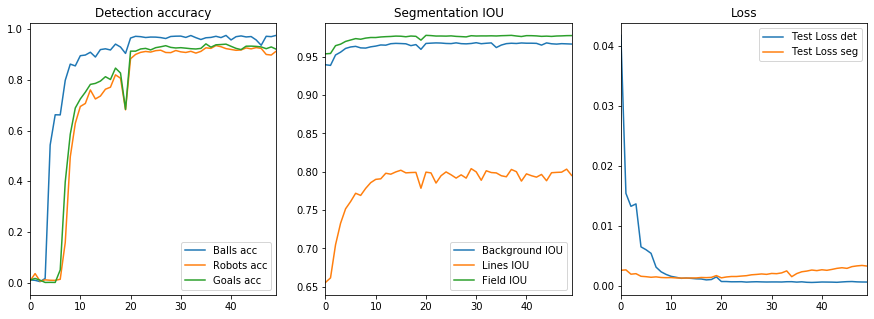

In [13]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
run_name='baseline'
log_loc = "".join([os.path.dirname(sys.path[0]),f'/Logs/{run_name}_log.csv'])

df =pd.read_csv(log_loc)
for name in ['Balls','Robots','Goals']:
    df[f'{name} acc']=df[f'{name} correct']/(df[f'{name} correct']+ df[f'{name} wrong']+df[f'{name} FP'])
print('Training time = ',str(datetime.timedelta(seconds=sum(df['time']))))


fig,ax = plt.subplots(1,3, figsize=(15,5))

ax[0]=df[['Balls acc','Robots acc','Goals acc']].plot(title = 'Detection accuracy',ax=ax[0])
ax[1]=df[['Background IOU','Lines IOU', 'Field IOU']].plot(title = 'Segmentation IOU',ax=ax[1])
ax[2]=df[['Test Loss det', 'Test Loss seg']].plot(title ='Loss',ax=ax[2])


In [10]:
model.load_state_dict(torch.load(f"/home/user/jacobs/cudavision/Models/DeepLab-baseline.pt"))    

val_loc = '/home/user/jacobs/jan/cudavision//data/Validation/'

for mode in modes:
    test_dataset[mode] = RobotsDataset(data_loc = val_loc,mode = mode,transform=args['transform'][mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)


test(args, model, device, test_loader['det'] , mode = 'det',logger=logger)
test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger)


Test set: det Average loss: 0.0207

Balls: F1: 0.9844, accuracy: 0.9693, recall: 0.9919, precision: 0.9771, FDR: 0.0229,
Goalposts: F1: 0.9543, accuracy: 0.9126, recall: 0.9677, precision: 0.9413, FDR: 0.0587,
Robots: F1: 0.9403, accuracy: 0.8873, recall: 0.9571, precision: 0.9241, FDR: 0.0759,

Test set: seg Average loss: 0.0551

Background: IOU: 0.9595, accuracy: 0.9931
Lines: IOU: 0.7930, accuracy: 0.9917
Field: IOU: 0.9749, accuracy: 0.9849
Total: IOU: 0.9092, accuracy: 0.9899


### Visualise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


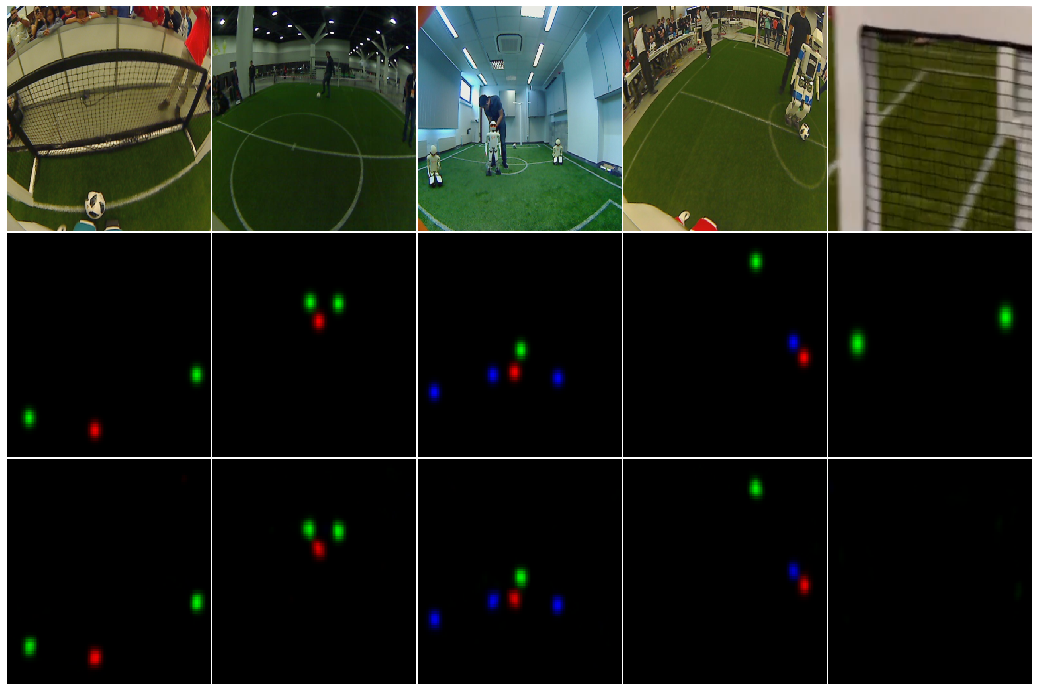

In [109]:
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms,utils
import matplotlib.gridspec as gridspec

for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode),
        mode_transforms.ToTensor(mode = mode)
    ])
for mode in modes:
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=transform_dict[mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
    
fig,ax = plt.subplots(3,5, figsize=(15,10))
plt.tight_layout()
plt.subplots_adjust(wspace=0.01,hspace=0.01)


for i,(im,target) in enumerate(test_loader['det']):
    model.eval
    with torch.no_grad():
        im_original=im[0]
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        im=transforms.ToPILImage()(im[0].cpu())
        trans=transforms.Normalize(mean=mean, std=std)
        ax[0,i].imshow(im)
        im=trans(transforms.ToTensor()(im))
        im=im.to(device)
        out = model(im[None,:,:,:])[0][0].cpu()
        ax[1,i].imshow(target[0].transpose(0,2).transpose(0,1))
        ax[2,i].imshow(out.transpose(0,2).transpose(0,1))
        if i>3:
            break
for i in range(3):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_aspect('auto')


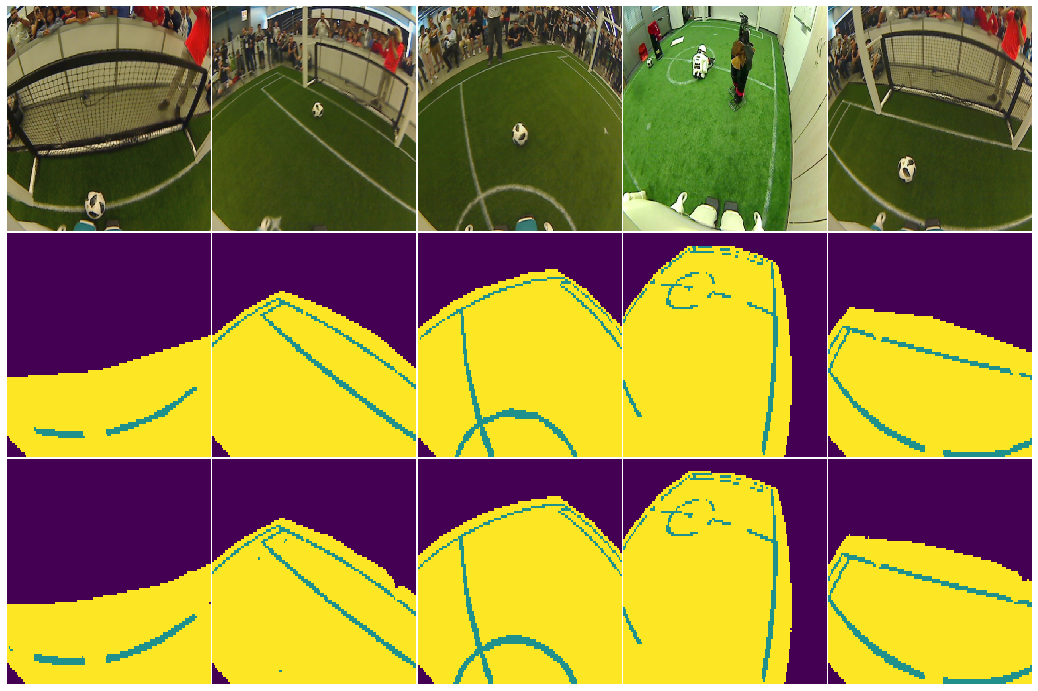

In [110]:
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms,utils
import matplotlib.gridspec as gridspec

for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode),
        mode_transforms.ToTensor(mode = mode)
    ])
for mode in modes:
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=transform_dict[mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
    
fig,ax = plt.subplots(3,5, figsize=(15,10))
plt.tight_layout()
plt.subplots_adjust(wspace=0.01,hspace=0.01)


for i,(im,target) in enumerate(test_loader['seg']):
    model.eval
    with torch.no_grad():
        im_original=im[0]
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        im=transforms.ToPILImage()(im[0].cpu())
        trans=transforms.Normalize(mean=mean, std=std)
        ax[0,i].imshow(im)
        im=trans(transforms.ToTensor()(im))
        im=im.to(device)
        out = model(im[None,:,:,:])[1][0].cpu()
        out = out.cpu().argmax(axis=0)
        ax[1,i].imshow(target[0])
        ax[2,i].imshow(out)
        if i>3:
            break
for i in range(3):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_aspect('auto')

# Data Augmentation

# Training on hard images

In [ ]:

import os
import pandas as pd
import numpy as np
import torch
import csv
from torch.utils.data import Dataset
from skimage.transform import resize,rescale
import skimage.io as io
from torchvision import transforms
from PIL import Image

# Local functions
from seg_xml_to_im import seg_to_im, xml_to_im
from seg_det_to_pil import seg_to_pil, xml_to_pil
from RobotData import RobotsDatasetBootstrapped


def bootstrap(mode,model,n):
    model.eval()
    if mode=='seg':
        df = pd.read_csv('/home/user/jacobs/jan/cudavision/data/Train/index_seg_boot.csv')
    if mode == 'det':
        df = pd.read_csv('/home/user/jacobs/jan/cudavision/data/Train/index_det_boot.csv')
    data_loc = '/home/user/jacobs/jan/cudavision/data/Train/'
    worst_name= n*[0]
    worst_value=n*[1]

    for index, row in df.iterrows():
        name = row[1]

        img_path = os.path.join('/home/user/jacobs/jan/cudavision/data/Train/image/',name)
        xml_path = os.path.join('/home/user/jacobs/jan/cudavision/data/Train/detection/',name)
        seg_path = os.path.join('/home/user/jacobs/jan/cudavision/data/Train/segmentation/',name)
        dec_path = os.path.join('/home/user/jacobs/jan/cudavision/data/Train/detection_pil/',name) #Change

        if os.path.isfile(img_path+'.jpg'):
            image = Image.open(img_path+'.jpg')
        elif os.path.isfile(img_path+'.png'):
            image = Image.open(img_path+'.png')
        else:
            print('error reading ' + img_path_seg)

        if mode=='seg':    
            target = seg_to_pil(seg_path + '.png')

        if mode == 'det':
            if os.path.exists(dec_path + '.png'): #Change
                target = Image.open(dec_path + '.png')
            else:
                target = xml_to_pil(xml_path + '.xml')
                target.save(dec_path + '.png')


        if transform_dict:
            image,target = transform_dict[mode]((image,target))
        image=image[None,:,:,:]
        if mode == 'seg':
            target=target[None,:,:]
        if mode == 'det':
            target=target[None,:,:,:]

        with torch.no_grad():
            if mode == 'det':
                x=model(image.to(device))[0].cpu()
                results = score(x,target)
                acc_b = get_score(results[0])[1]
                acc_g = get_score(results[1])[1]
                acc_r = get_score(results[2])[1]
                acc = np.mean([acc_b,acc_g,acc_r])
            if mode == 'seg':
                x=model(image.to(device))[1].cpu()
                acc,_=IOU_run(x,target)
                acc=np.mean(acc)

        for j in range(n):  
            if acc<worst_value[j]:
                worst_name.insert(j,name)
                worst_name.pop()
                worst_value.insert(j,acc)
                worst_value.pop()
                break
                
    print(worst_value)    
    print(worst_name)    
    with open(data_loc + f'index_{mode}_boot.csv', mode='a') as index:
        index_writer = csv.writer(index, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        i=len(df)
        for name in worst_name:
            index_writer.writerow([i,name])
            i+=1


In [3]:

input_size = (4*3*32,4*4*32) # (5*3*32,5*4*32)
transform_dict = {}

for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode),
        mode_transforms.ToTensor(mode = mode),
        mode_transforms.Normalize(),
    ])

args = {'batch_size':12,
        'test_batch_size':32,
        'epochs': 25,
        'size_after_transform' : input_size,
        'lr': 0.0001,
        'max_lr':0.005,
        'gamma':0.7,
        'seed': 1234,
        'log_interval':10,
        'save_model':True,
        'l1':100,
        'l2':1,
        'l3':0,
        'transform' : transform_dict,
}

torch.manual_seed(args['seed'])


#train_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Train/'])
#test_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Test/'])

train_loc = "".join([os.path.dirname(sys.path[0]),'/data/Train/'])
test_loc = "".join([os.path.dirname(sys.path[0]),'/data/Test/'])

train_dataset = dict.fromkeys(modes, None) 
train_loader = dict.fromkeys(modes, None)
test_dataset = dict.fromkeys(modes, None) 
test_loader = dict.fromkeys(modes, None)

for mode in modes:
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=args['transform'][mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
train_dataset['concurrent'] = RobotsDatasetBootstrapped(data_loc = train_loc,transform_dict=args['transform'])
train_loader['concurrent'] = torch.utils.data.DataLoader(train_dataset['concurrent'],batch_size=args['batch_size'], shuffle=False)

model = DeepLab(3,3,backbone='resnet18').to(device)

run_loc= "".join([os.path.dirname(sys.path[0]),'/Logs/experiments.csv'])
if os.path.isfile(run_loc):
    df = pd.read_csv(run_loc)
    run_id = max(df['run_id'])+1
else:
    run_id=0

run_name='hard'
log_loc = "".join([os.path.dirname(sys.path[0]),f'/Logs/{run_name}_log.csv'])
logger = Logger(run_loc,log_loc,run_id,args)
    
optimizer = optim.Adam(model.parameters(), 0.0007)
scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)


resnet18


In [ ]:
for epoch in range(26, args['epochs'] + 26):
    train_concurrent(args, model, device, train_loader['concurrent'], optimizer, epoch,logger=logger)
    test(args, model, device, test_loader['det'] , mode = 'det',logger=logger,visualise=False)
    test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger,visualise=False)
    scheduler.step()
    logger.log_data()
    torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_{epoch//5}.pt")
    if epoch>9 and epoch%2==0:
        bootstrap('seg',model,100)
        bootstrap('det',model,600)
    
torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_final.pt")


# Upsampling
The DeepLabv3 paper suggests training with upsampling works better.

In [3]:

input_size = (4*3*32,4*4*32) # (5*3*32,5*4*32)
transform_dict = {}

for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode,downsample=False),
        mode_transforms.ToTensor(mode = mode),
        mode_transforms.Normalize(),
    ])

args = {'batch_size':12,
        'test_batch_size':32,
        'epochs': 25,
        'size_after_transform' : input_size,
        'lr': 0.0001,
        'max_lr':0.005,
        'gamma':0.7,
        'seed': 1234,
        'log_interval':50,
        'save_model':True,
        'l1':100,
        'l2':1,
        'l3':0,
        'transform' : transform_dict,
}

torch.manual_seed(args['seed'])


#train_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Train/'])
#test_loc = "".join([os.path.dirname(sys.path[0]),'/test_data/Test/'])

train_loc = "".join([os.path.dirname(sys.path[0]),'/data/Train/'])
test_loc = "".join([os.path.dirname(sys.path[0]),'/data/Test/'])

train_dataset = dict.fromkeys(modes, None) 
train_loader = dict.fromkeys(modes, None)
test_dataset = dict.fromkeys(modes, None) 
test_loader = dict.fromkeys(modes, None)

for mode in modes:
    train_dataset[mode] = RobotsDataset(data_loc = train_loc,mode = mode,transform=args['transform'][mode])
    train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=False)
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=args['transform'][mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
train_dataset['concurrent'] = RobotsDatasetConcurrent(data_loc = train_loc,transform_dict=args['transform'])
train_loader['concurrent'] = torch.utils.data.DataLoader(train_dataset['concurrent'],batch_size=args['batch_size'], shuffle=False)

model = DeepLab(3,3,backbone='resnet18',upsample=True).to(device)

run_loc= "".join([os.path.dirname(sys.path[0]),'/Logs/experiments.csv'])
if os.path.isfile(run_loc):
    df = pd.read_csv(run_loc)
    run_id = max(df['run_id'])+1
else:
    run_id=0

run_name='upsample'
log_loc = "".join([os.path.dirname(sys.path[0]),f'/Logs/{run_name}_log.csv'])
logger = Logger(run_loc,log_loc,run_id,args)
    
optimizer = optim.Adam(model.parameters(), 0.0007)
scheduler = CyclicLR(optimizer, base_lr=args['lr'],max_lr=args['max_lr'],cycle_momentum=False)


resnet18


In [5]:
for epoch in range(1, args['epochs'] + 1):
    train_concurrent(args, model, device, train_loader['concurrent'], optimizer, epoch,logger=logger)
    test(args, model, device, test_loader['det'] , mode = 'det',logger=logger,visualise=False)
    test(args, model, device, test_loader['seg'], mode = 'seg',logger=logger,visualise=False)
    scheduler.step()
    logger.log_data()
    torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_{epoch//5}0.pt")
    
torch.save(model.state_dict(), f"/home/user/jacobs/jan/cudavision/Models/{run_name}_model_final.pt")

/home/user/jacobs/jan/cudavision/criterion.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = l2*nll(F.log_softmax(output[1]), seg.long()) \


Train Epoch concurrent: 1 [0/6195(0%)]	Loss: 6.590833, time: 1.6564760208129883
Train Epoch concurrent: 1 [600/6195(10%)]	Loss: 0.890487, time: 39.532984018325806
Train Epoch concurrent: 1 [1200/6195(19%)]	Loss: 0.365765, time: 39.751227617263794
Train Epoch concurrent: 1 [1800/6195(29%)]	Loss: 0.277757, time: 39.6622314453125
Train Epoch concurrent: 1 [2400/6195(39%)]	Loss: 0.212982, time: 39.794660329818726
Train Epoch concurrent: 1 [3000/6195(48%)]	Loss: 0.197187, time: 39.78974485397339
Train Epoch concurrent: 1 [3600/6195(58%)]	Loss: 0.169659, time: 39.75792384147644
Train Epoch concurrent: 1 [4200/6195(68%)]	Loss: 0.146447, time: 39.83614110946655
Train Epoch concurrent: 1 [4800/6195(77%)]	Loss: 0.130675, time: 39.67727184295654
Train Epoch concurrent: 1 [5400/6195(87%)]	Loss: 0.108313, time: 39.68206787109375
Train Epoch concurrent: 1 [6000/6195(97%)]	Loss: 0.095780, time: 39.76462912559509

Test set: det Average loss: 0.0304

Balls: F1: 0.01, accuracy: 0.01, recall: 0.17, preci

Train Epoch concurrent: 6 [4800/6195(77%)]	Loss: 0.017306, time: 39.827757120132446
Train Epoch concurrent: 6 [5400/6195(87%)]	Loss: 0.015731, time: 39.82477879524231
Train Epoch concurrent: 6 [6000/6195(97%)]	Loss: 0.012073, time: 39.85345673561096

Test set: det Average loss: 0.0148

Balls: F1: 0.76, accuracy: 0.61, recall: 0.92, precision: 0.65, FDR: 0.35,
Goalposts: F1: 0.33, accuracy: 0.20, recall: 0.50, precision: 0.24, FDR: 0.76,
Robots: F1: 0.09, accuracy: 0.05, recall: 0.18, precision: 0.06, FDR: 0.94,
mean evaluation time: 0.0034 at batch size 32

Test set: seg Average loss: 0.0015

Background: IOU: 0.96, accuracy: 0.99
Lines: IOU: 0.75, accuracy: 0.99
Field: IOU: 0.97, accuracy: 0.98
Total: IOU: 0.89, accuracy: 0.99
mean evaluation time: 0.0034 at batch size 32
writing logs to  /home/user/jacobs/jan/cudavision/Logs/upsample_log.csv
Train Epoch concurrent: 7 [0/6195(0%)]	Loss: 0.014226, time: 0.7439906597137451
Train Epoch concurrent: 7 [600/6195(10%)]	Loss: 0.015503, time: 3

Train Epoch concurrent: 12 [0/6195(0%)]	Loss: 0.004807, time: 0.751084566116333
Train Epoch concurrent: 12 [600/6195(10%)]	Loss: 0.005921, time: 39.76300120353699
Train Epoch concurrent: 12 [1200/6195(19%)]	Loss: 0.004787, time: 39.980464696884155
Train Epoch concurrent: 12 [1800/6195(29%)]	Loss: 0.004531, time: 39.89812922477722
Train Epoch concurrent: 12 [2400/6195(39%)]	Loss: 0.004380, time: 39.77907991409302
Train Epoch concurrent: 12 [3000/6195(48%)]	Loss: 0.003636, time: 39.85969662666321
Train Epoch concurrent: 12 [3600/6195(58%)]	Loss: 0.003821, time: 39.82648038864136
Train Epoch concurrent: 12 [4200/6195(68%)]	Loss: 0.004590, time: 39.8359169960022
Train Epoch concurrent: 12 [4800/6195(77%)]	Loss: 0.004136, time: 39.778048038482666
Train Epoch concurrent: 12 [5400/6195(87%)]	Loss: 0.004299, time: 39.778544902801514
Train Epoch concurrent: 12 [6000/6195(97%)]	Loss: 0.002975, time: 39.822444438934326

Test set: det Average loss: 0.0014

Balls: F1: 0.96, accuracy: 0.92, recall: 

Train Epoch concurrent: 17 [4200/6195(68%)]	Loss: 0.002752, time: 39.87105393409729
Train Epoch concurrent: 17 [4800/6195(77%)]	Loss: 0.003053, time: 39.78308439254761
Train Epoch concurrent: 17 [5400/6195(87%)]	Loss: 0.002906, time: 39.788243770599365
Train Epoch concurrent: 17 [6000/6195(97%)]	Loss: 0.002334, time: 39.86917495727539

Test set: det Average loss: 0.0011

Balls: F1: 0.97, accuracy: 0.94, recall: 1.00, precision: 0.94, FDR: 0.06,
Goalposts: F1: 0.91, accuracy: 0.83, recall: 0.94, precision: 0.87, FDR: 0.13,
Robots: F1: 0.85, accuracy: 0.75, recall: 0.88, precision: 0.83, FDR: 0.17,
mean evaluation time: 0.0034 at batch size 32

Test set: seg Average loss: 0.0014

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.78, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0033 at batch size 32
writing logs to  /home/user/jacobs/jan/cudavision/Logs/upsample_log.csv
Train Epoch concurrent: 18 [0/6195(0%)]	Loss: 0.002313, ti

/home/user/jacobs/jan/cudavision/metric_segmentation.py:51: RuntimeWarning: invalid value encountered in true_divide
  IOU_imagewise[:,i] = true_positives_imagewise[cat]/(true_positives_imagewise[cat] + false_positives_imagewise[cat] + false_negatives_imagewise[cat])



Test set: seg Average loss: 0.0013

Background: IOU: 0.97, accuracy: 0.99
Lines: IOU: 0.78, accuracy: 0.99
Field: IOU: 0.98, accuracy: 0.99
Total: IOU: 0.91, accuracy: 0.99
mean evaluation time: 0.0033 at batch size 32
writing logs to  /home/user/jacobs/jan/cudavision/Logs/upsample_log.csv
Train Epoch concurrent: 23 [0/6195(0%)]	Loss: 0.003285, time: 0.7480218410491943
Train Epoch concurrent: 23 [600/6195(10%)]	Loss: 0.003325, time: 39.67970514297485
Train Epoch concurrent: 23 [1200/6195(19%)]	Loss: 0.002947, time: 39.92035269737244
Train Epoch concurrent: 23 [1800/6195(29%)]	Loss: 0.002872, time: 39.835880517959595
Train Epoch concurrent: 23 [2400/6195(39%)]	Loss: 0.002966, time: 40.17308568954468
Train Epoch concurrent: 23 [3000/6195(48%)]	Loss: 0.002344, time: 40.35143685340881
Train Epoch concurrent: 23 [3600/6195(58%)]	Loss: 0.002654, time: 40.273186445236206
Train Epoch concurrent: 23 [4200/6195(68%)]	Loss: 0.002582, time: 40.228267669677734
Train Epoch concurrent: 23 [4800/6195

Training time =  3:21:07.318036
final results
resnet18

Test set: det Average loss: 0.0008

Balls: F1: 0.99, accuracy: 0.97, recall: 1.00, precision: 0.97, FDR: 0.03,
Goalposts: F1: 0.96, accuracy: 0.93, recall: 0.97, precision: 0.96, FDR: 0.04,
Robots: F1: 0.95, accuracy: 0.90, recall: 0.96, precision: 0.94, FDR: 0.06,


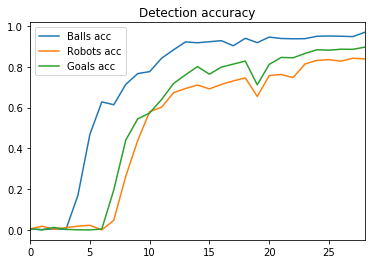

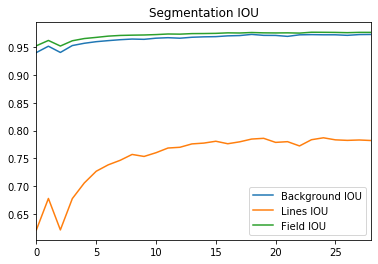

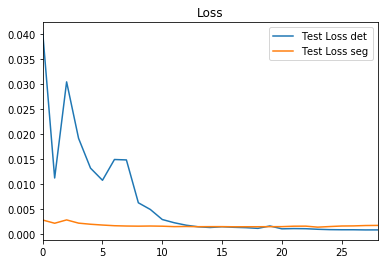

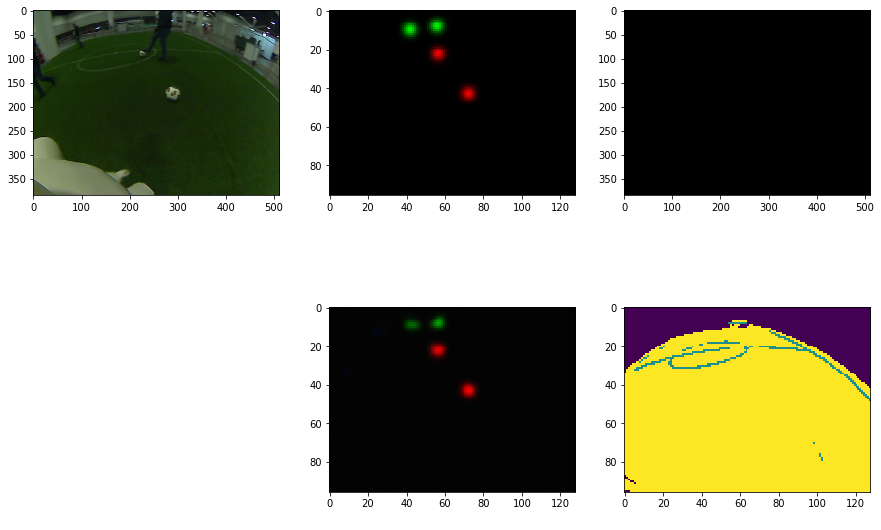

mean evaluation time: 0.0038 at batch size 32

Test set: seg Average loss: 0.0026

Background: IOU: 0.96, accuracy: 0.99
Lines: IOU: 0.69, accuracy: 0.99
Field: IOU: 0.97, accuracy: 0.98
Total: IOU: 0.87, accuracy: 0.99


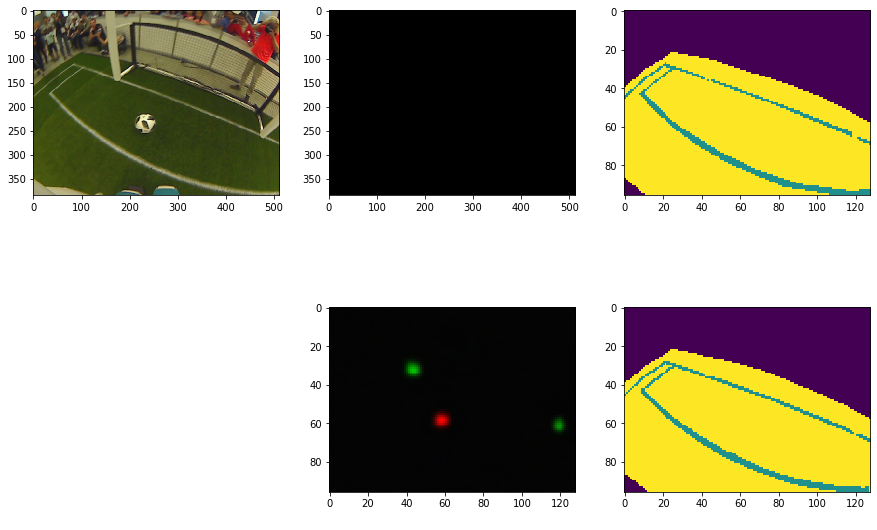

mean evaluation time: 0.0037 at batch size 32


In [5]:
import datetime

df =pd.read_csv(log_loc)

for name in ['Balls','Robots','Goals']:
    df[f'{name} acc']=df[f'{name} correct']/(df[f'{name} correct']+ df[f'{name} wrong']+df[f'{name} FP'])
print('Training time = ',str(datetime.timedelta(seconds=sum(df['time']))))

df[['Balls acc','Robots acc','Goals acc']].plot(title = 'Detection accuracy')
df[['Background IOU','Lines IOU', 'Field IOU']].plot(title = 'Segmentation IOU')
df[['Test Loss det', 'Test Loss seg']].plot(title ='Loss')


for mode in modes:
    transform_dict[mode] = transforms.Compose([
        mode_transforms.Resize(input_size,mode=mode),
        mode_transforms.ToTensor(mode = mode),
        mode_transforms.Normalize(),
    ])

for mode in modes:
    train_dataset[mode] = RobotsDataset(data_loc = train_loc,mode = mode,transform=args['transform'][mode])
    train_loader[mode] = torch.utils.data.DataLoader(train_dataset[mode],batch_size=args['batch_size'], shuffle=False)
    test_dataset[mode] = RobotsDataset(data_loc = test_loc,mode = mode,transform=args['transform'][mode])
    test_loader[mode] = torch.utils.data.DataLoader(test_dataset[mode],batch_size=args['test_batch_size'], shuffle=False)
    
print('final results')
model_test = DeepLab(3,3,backbone='resnet18').to(device)
model_test.load_state_dict(torch.load(f"/home/user/jacobs/jan/cudavision/Models/upsample_model_50.pt"))    
test(args, model_test, device, test_loader['det'] , mode = 'det',logger=logger,visualise=True)
test(args, model_test, device, test_loader['seg'], mode = 'seg',logger=logger,visualise=True)
